In [430]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
# Useful parameters for reproducibility
# SEED = 1234
# torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True
from sklearn.model_selection import train_test_split

import random, os
from tqdm import tqdm

from PIL import Image
from torchvision import datasets, transforms, utils
from os import walk
from os.path import join, normpath
import pretty_midi

from math import floor
import time
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Here, we define our data loader.

In [431]:
class PianoMusic(data.Dataset):
  def __init__(self, midi_dir=None, transform=None):
    super().__init__()
    if midi_dir is None: # Empty dataset
      self.file_list = []
      self.loaded = []
    else: # Non-empty dataset
      self.file_list = list(os.listdir(midi_dir))
      self.loaded = [None] * len(self.file_list)
    self.root_dir = midi_dir
    self.transform = transform

  def __len__(self):
      return len(self.file_list)


  def __getitem__(self, index):
      try:
        if self.loaded[index] is None:
          file_name = self.file_list[index]
          path = normpath(join(self.root_dir, file_name))
          music = torch.Tensor(pretty_midi.PrettyMIDI(path).get_piano_roll())

          music = torch.transpose(music, 0, 1) # original data has dim 0 = notes, dim 1 = time step, we want the opposite
          chords, durations = torch.unique_consecutive(music, return_counts=True, dim=0)
          
          self.loaded[index] = {'chords':chords, 'durations':durations}

        return self.loaded[index] if self.transform is None else self.transform(self.loaded[index])
      except IndexError:
        raise IndexError("Item does not exist, have you loaded the MIDI files correctly?")

  def _create_from_self(self, file_list):
    new_dataset = PianoMusic()
    new_dataset.file_list = file_list
    new_dataset.loaded = [None] * len(file_list)
    new_dataset.root_dir = self.root_dir
    new_dataset.transform = self.transform
    return new_dataset


  def get_path(self, index):
    try:
      file_name = self.file_list[index]
      path = normpath(join(self.root_dir, file_name))
      return path
    except IndexError:
      raise IndexError("Item does not exist, have you loaded the MIDI files correctly?")

  def splits(self, test_size=0.3):
    train_files, test_files = train_test_split(self.file_list, test_size=test_size)
    return self._create_from_self(train_files), self._create_from_self(test_files)

Here, we create our sample and we also define a collate_fn. A collate_fn is used a soart of a way to moddify de input datas. We need it because in our case, not every tensor is the same length (some music can be longer than other). We also define the transformer we will use on our datas. Here, we are doing some padding tu make sure every tensor in the sample is the same size (we add zeors to the smaller tensors to make them allign with the size of the biggest

In [432]:
def collate_fn(batch): # In a batch, not all samples are the same size, we need them to
  musics_chords = [row['chords'] for row in batch]
  musics_durations = [row['durations'] for row in batch]
  lengths = [chords.shape[0] for chords in musics_chords]
  returned = pad_sequence(musics_chords, padding_value=0), pad_sequence(musics_durations, padding_value=0), torch.tensor(lengths)
  return returned

def transform(element): # Turns all velocity values to to 0-1, and extract piano notes
  chords = element['chords']
  chords = torch.where(chords != 0, 1, 0)
  chords = chords[:, 21:109] # 109-21 = 88 => the piano notes of a piano roll
  chords = chords.float()
  totals = chords.sum(dim=1).reshape((-1,1)) # We want vectors to sum to one
  totals[totals == 0] = 1
  return {'chords': chords / totals, 'durations': element['durations'].float()}

Here is the function we use to plot some pianoroll (if we want to "inspect" the data). This function is able to only plot ONE pianoroll at a time ! It would be cool to modify it to be able to plot several pianoroll in the same display (but not of prior importance)

In [433]:
def plotPianoRoll(pianoroll, path):
    to_plot = torch.transpose(pianoroll, 0, 1)
    fig, ax = plt.subplots(figsize=(160, 60))
    ax.imshow(to_plot, cmap='binary', interpolation='nearest')
    ax.set_title(path)
    ax.invert_yaxis()
    ax.set_xlabel('Nbr Timesteps')
    ax.set_ylabel('Note value')
    plt.show()

In [434]:
class DurationLSTMMusic(nn.Module):
    def __init__(self, note_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        self.rnn = nn.LSTM(note_dim, hidden_dim, num_layers=n_layers, dropout=dropout)
        self.fc_output = nn.Linear(hidden_dim, output_dim)
        self.fc_duration = nn.Linear(output_dim, 1)
        self.output_softmax = nn.Softmax(dim=-1)

    def forward(self, chords, durations, lengths=None):
        if lengths is None: # No batch
            scaled_chords = chords * durations.unsqueeze(-1)
            rnn_output, (hidden, cell) = self.rnn(scaled_chords)
            rnn_output_last = rnn_output[-1:]
        else: # batch
            scaled_chords = chords * durations.unsqueeze(-1)
            packed_chords = nn.utils.rnn.pack_padded_sequence(scaled_chords, lengths, enforce_sorted=False)
            rnn_packed_output, (hidden, cell) = self.rnn(packed_chords)
            rnn_output, output_lengths = nn.utils.rnn.pad_packed_sequence(rnn_packed_output)
            # output is padded, longest_seq_dim x batch_size x note_dim
            # we have 1 x batch_size x note_dim, we took last note of each batch, we then just return element 0 => batch_size x note_dim
            rnn_output_last = torch.stack([rnn_output[last - 1] for last in output_lengths])[0]
        output_funnelled = self.fc_output(rnn_output_last)
        output_durations = self.fc_duration(output_funnelled)
        output_chords = self.output_softmax(output_funnelled)
        output = output_chords * output_durations
        return output

class DurationRNNMusic(nn.Module):
    def __init__(self, note_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        self.rnn = nn.RNN(note_dim, hidden_dim, num_layers=n_layers, dropout=dropout, nonlinearity="relu")
        self.fc_output = nn.Linear(hidden_dim, output_dim)
        self.fc_duration = nn.Linear(output_dim, 1)
        self.output_softmax = nn.Softmax(dim=-1)

    def forward(self, chords, durations, lengths=None):
        if lengths is None: # No batch
            scaled_chords = chords * durations.unsqueeze(-1)
            rnn_output, hn = self.rnn(scaled_chords)
            rnn_output_last = rnn_output[-1:]
        else: # batch
            scaled_chords = chords * durations.unsqueeze(-1)
            packed_chords = nn.utils.rnn.pack_padded_sequence(scaled_chords, lengths, enforce_sorted=False)      
            rnn_packed_output, hn = self.rnn(packed_chords)
            rnn_output, output_lengths = nn.utils.rnn.pad_packed_sequence(rnn_packed_output)
            # output is padded, longest_seq_dim x batch_size x note_dim
            # we have 1 x batch_size x note_dim, we took last note of each batch, we then just return element 0 => batch_size x note_dim
            rnn_output_last = torch.stack([rnn_output[last - 1] for last in output_lengths])[0]
        output_funnelled = self.fc_output(rnn_output_last)
        output_durations = self.fc_duration(output_funnelled)
        output_chords = self.output_softmax(output_funnelled)
        output = output_chords * output_durations
        return output

In [435]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [436]:
def train(model, dataloader, optimizer, criterion, step_size=4, window_size=None):
    epoch_loss = 0
    loop_count = 0

    model.train()

    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader), leave=False):
        chords, durations, musics_lengths = batch
        chords = chords.to(DEVICE)
        durations = durations.to(DEVICE)
        updated_lengths = torch.stack([musics_lengths, torch.zeros(musics_lengths.size())])

        for j in tqdm(range(1, int(len(chords) / step_size)), total=int(len(chords) / step_size), position = 1, leave=False):
            optimizer.zero_grad()
            if window_size is None:
                updated_lengths[1] = 1 + j * step_size
                chords_input = chords[0:1 + j * step_size]
                durations_input = durations[0:1 + j * step_size]
            elif window_size > 1 + j * step_size: # there is not enough chords for the window
                continue
            else: # A window size fixes the length of the input, but we do not want to repropagate padding
                updated_lengths[1] = window_size
                chords_input = chords[1 + j * step_size - window_size:1 + j * step_size]
                durations_input = durations[1 + j * step_size - window_size:1 + j * step_size]

            # The length of a music is the minimum between its unpadded length and the current loop
            next_measure = model(chords_input, durations_input, updated_lengths.min(dim=0)[0])

            if window_size: # We ignore the loss computed when the window size includes padding
                old_reduction = criterion.reduction
                criterion.reduction = 'none'
                unreduced_loss = criterion(next_measure, chords[1 + j * step_size] * durations[1 + j * step_size].unsqueeze(-1))
                for k,length in enumerate(musics_lengths):
                    if musics_lengths[k] <= 1 + j * step_size:
                        unreduced_loss[k] = 0
                loss = unreduced_loss.mean()
                criterion.reduction = old_reduction
            else:
                loss = criterion(next_measure, chords[1 + j * step_size] * durations[1 + j * step_size].unsqueeze(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            loop_count += 1

    return epoch_loss / loop_count

def evaluate(model, dataloader, criterion, step_size=4, window_size=None):
    epoch_loss = 0
    loop_count = 0

    model.eval()

    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader), leave=False):
        chords, durations, musics_lengths = batch
        chords = chords.to(DEVICE)
        durations = durations.to(DEVICE)
        updated_lengths = torch.stack([musics_lengths, torch.zeros(musics_lengths.size())])

        for j in tqdm(range(1, int(len(chords) / step_size)), total=int(len(chords) / step_size), position = 1, leave=False):
            if window_size is None:
                updated_lengths[1] = 1 + j * step_size
                chords_input = chords[0:1 + j * step_size]
                durations_input = durations[0:1 + j * step_size]
            elif window_size > 1 + j * step_size: # there is not enough chords for the window
                continue
            else: # A window size fixes the length of the input, but we do not want to repropagate padding
                updated_lengths[1] = window_size
                chords_input = chords[1 + j * step_size - window_size:1 + j * step_size]
                durations_input = durations[1 + j * step_size - window_size:1 + j * step_size]

            # The length of a music is the minimum between its unpadded length and the current loop
            next_measure = model(chords_input, durations_input, updated_lengths.min(dim=0)[0])

            if window_size: # We ignore the loss computed when the window size includes padding
                old_reduction = criterion.reduction
                criterion.reduction = 'none'
                unreduced_loss = criterion(next_measure, chords[1 + j * step_size] * durations[1 + j * step_size].unsqueeze(-1))
                for k,length in enumerate(musics_lengths):
                    if musics_lengths[k] <= 1 + j * step_size:
                        unreduced_loss[k] = 0
                loss = unreduced_loss.mean()
                criterion.reduction = old_reduction
            else:
                loss = criterion(next_measure, chords[1 + j * step_size] * durations[1 + j * step_size].unsqueeze(-1))
            epoch_loss += loss.item()
            loop_count += 1

    return epoch_loss / loop_count

In [437]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
  
def compute_epochs(model, train_dataloader, test_dataloader, criterion, optimizer, n_epochs, step_size=4, window_size=False, best_path=None, last_path=None, verbose=True):
  best_test_loss = float('inf')
  
  criterion = criterion.to(DEVICE)
  
  train_losses = []
  test_losses = []
  epoch_times = []

  for epoch in range(n_epochs):
    start_time = time.time()
    train_loss = train(model, train_dataloader, optimizer, criterion, step_size=step_size, window_size=window_size)
    test_loss = evaluate(model, test_dataloader, criterion, step_size=step_size, window_size=window_size)

    end_time = time.time()
    

    if best_path and test_loss < best_test_loss:
      best_test_loss = test_loss
      torch.save(model.state_dict(), best_path)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    epoch_times.append(end_time - start_time)

    if verbose:
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss}')
      print(f'\t Test Loss: {test_loss}')
  
  if last_path:
      torch.save(model.state_dict(), last_path)
    
  return model, train_losses, test_losses, epoch_times

In [438]:
NOTE_DIM = 88
HIDDEN_DIM = 256
OUTPUT_DIM = 88
N_LAYERS = 4
DROPOUT = 0.3

In [439]:

model = DurationLSTMMusic(NOTE_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
model.to(DEVICE)
print(f'Number of parameters : {count_parameters(model)}')

dataset = PianoMusic("./js/all", transform=transform)
train_dataset, test_dataset = dataset.splits()


train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=0)
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=0)

model, train_losses, test_losses, epoch_times = compute_epochs(model, train_dataloader, test_dataloader, nn.MSELoss(), optim.Adam(model.parameters()), n_epochs=100, 
                                                                   step_size=4,
                                                                   window_size=8, 
                                                                   best_path=f'model-best.pt',
                                                                   last_path=f'model-last.pt', 
                                                                   verbose=True)
pd.DataFrame.from_dict({'train_loss':train_losses, 'test_loss': test_losses, 'epoch_time': epoch_times}).to_csv(f'model.csv')

Number of parameters : 1956017


Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 8.320579450025603
	 Test Loss: 7.861434232229474


Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 8.616468113229097
	 Test Loss: 7.432402648932332


Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 7.65822583631329
	 Test Loss: 7.763613179162308


Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 7.754419564544367
	 Test Loss: 8.007568400481652


Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 7.627430330562804
	 Test Loss: 8.066838743144206


Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 7.852743330516966
	 Test Loss: 7.928133277391845


Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 7.697543100960422
	 Test Loss: 8.270312952118761


Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 8.007211037945968
	 Test Loss: 8.18400645933368


Epoch: 09 | Epoch Time: 0m 3s
	Train Loss: 7.579865350995375
	 Test Loss: 7.679032007797381


Epoch: 10 | Epoch Time: 0m 3s
	Train Loss: 7.783347627735353
	 Test Loss: 7.726189102182228


Epoch: 11 | Epoch Time: 0m 3s
	Train Loss: 7.663781036954859
	 Test Loss: 7.650208540997663


Epoch: 12 | Epoch Time: 0m 3s
	Train Loss: 7.807227217276162
	 Test Loss: 7.771225558085875


Epoch: 13 | Epoch Time: 0m 3s
	Train Loss: 7.9802231313741725
	 Test Loss: 8.115456105283137


Epoch: 14 | Epoch Time: 0m 3s
	Train Loss: 8.058114843925944
	 Test Loss: 7.940557065504518


Epoch: 15 | Epoch Time: 0m 3s
	Train Loss: 8.17913216412602
	 Test Loss: 7.652105470771318


Epoch: 16 | Epoch Time: 0m 3s
	Train Loss: 7.73016843990942
	 Test Loss: 7.7710425549008875


Epoch: 17 | Epoch Time: 0m 3s
	Train Loss: 7.3417557131530895
	 Test Loss: 8.238116526603699


Epoch: 18 | Epoch Time: 0m 3s
	Train Loss: 7.768246932162179
	 Test Loss: 7.724605871872469


Epoch: 19 | Epoch Time: 0m 3s
	Train Loss: 8.283004207603101
	 Test Loss: 7.648435194840592


Epoch: 20 | Epoch Time: 0m 3s
	Train Loss: 8.081150164541144
	 Test Loss: 7.792417725209486


Epoch: 21 | Epoch Time: 0m 3s
	Train Loss: 7.617629038757748
	 Test Loss: 8.087391356344927


Epoch: 22 | Epoch Time: 0m 3s
	Train Loss: 8.0407807086812
	 Test Loss: 7.68164430744946


Epoch: 23 | Epoch Time: 0m 3s
	Train Loss: 7.749616339600464
	 Test Loss: 8.359319056455906


Epoch: 24 | Epoch Time: 0m 3s
	Train Loss: 7.826984187188957
	 Test Loss: 7.784520617061919


Epoch: 25 | Epoch Time: 0m 3s
	Train Loss: 7.684898672518751
	 Test Loss: 8.042285095204363


Epoch: 26 | Epoch Time: 0m 3s
	Train Loss: 8.123742207164925
	 Test Loss: 8.37814827844864


Epoch: 27 | Epoch Time: 0m 3s
	Train Loss: 7.692264208262381
	 Test Loss: 7.532415625084652


Epoch: 28 | Epoch Time: 0m 3s
	Train Loss: 7.869027773562115
	 Test Loss: 7.548185297257298


Epoch: 29 | Epoch Time: 0m 2s
	Train Loss: 8.207546449832472
	 Test Loss: 7.952169473732219


Epoch: 30 | Epoch Time: 0m 3s
	Train Loss: 7.577062255392472
	 Test Loss: 7.691248819570649


Epoch: 31 | Epoch Time: 0m 3s
	Train Loss: 7.888987421028076
	 Test Loss: 7.809101916849613


Epoch: 32 | Epoch Time: 0m 3s
	Train Loss: 7.518171488901609
	 Test Loss: 7.986426342018815


Epoch: 33 | Epoch Time: 0m 3s
	Train Loss: 7.685244955464241
	 Test Loss: 7.592007697130857


Epoch: 34 | Epoch Time: 0m 3s
	Train Loss: 7.640889402072538
	 Test Loss: 8.045860282012395


Epoch: 35 | Epoch Time: 0m 3s
	Train Loss: 7.625058959063874
	 Test Loss: 7.537862485379316


Epoch: 36 | Epoch Time: 0m 3s
	Train Loss: 7.755949644446373
	 Test Loss: 7.95921445105757


Epoch: 37 | Epoch Time: 0m 3s
	Train Loss: 7.265883630410032
	 Test Loss: 7.817559061330908


Epoch: 38 | Epoch Time: 0m 3s
	Train Loss: 7.387160793899401
	 Test Loss: 7.281698534997662


Epoch: 39 | Epoch Time: 0m 3s
	Train Loss: 7.812951070578742
	 Test Loss: 7.811779417605563


Epoch: 40 | Epoch Time: 0m 3s
	Train Loss: 7.377129152827306
	 Test Loss: 6.966288555945669


Epoch: 41 | Epoch Time: 0m 3s
	Train Loss: 7.2132189814434495
	 Test Loss: 7.709102209876566


Epoch: 42 | Epoch Time: 0m 3s
	Train Loss: 6.655102725896201
	 Test Loss: 7.033330134474314


Epoch: 43 | Epoch Time: 0m 3s
	Train Loss: 6.703389787609162
	 Test Loss: 7.276688376839242


Epoch: 44 | Epoch Time: 0m 3s
	Train Loss: 6.9839397765217575
	 Test Loss: 6.8577705675756535


Epoch: 45 | Epoch Time: 0m 3s
	Train Loss: 6.688001645252844
	 Test Loss: 7.123282645405694


Epoch: 46 | Epoch Time: 0m 3s
	Train Loss: 6.819714732259233
	 Test Loss: 6.962042296220633


Epoch: 47 | Epoch Time: 0m 3s
	Train Loss: 6.326684542000294
	 Test Loss: 6.968936736664076


Epoch: 48 | Epoch Time: 0m 3s
	Train Loss: 6.624401765715244
	 Test Loss: 6.926262889262084


Epoch: 49 | Epoch Time: 0m 3s
	Train Loss: 6.268912410200165
	 Test Loss: 6.875881199373139


Epoch: 50 | Epoch Time: 0m 3s
	Train Loss: 6.153035975393972
	 Test Loss: 7.619253701916555


Epoch: 51 | Epoch Time: 0m 3s
	Train Loss: 6.2878399548727435
	 Test Loss: 7.190301977008222


Epoch: 52 | Epoch Time: 0m 3s
	Train Loss: 6.18917816981478
	 Test Loss: 7.582402808175368


Epoch: 53 | Epoch Time: 0m 3s
	Train Loss: 6.256067537855018
	 Test Loss: 7.255118578497101


Epoch: 54 | Epoch Time: 0m 3s
	Train Loss: 6.030556060373783
	 Test Loss: 6.573802451404293


Epoch: 55 | Epoch Time: 0m 3s
	Train Loss: 6.040026241498536
	 Test Loss: 6.492218645519755


Epoch: 56 | Epoch Time: 0m 3s
	Train Loss: 5.343197530896767
	 Test Loss: 6.857950503861203


Epoch: 57 | Epoch Time: 0m 3s
	Train Loss: 5.772700598666454
	 Test Loss: 6.640775991992636


Epoch: 58 | Epoch Time: 0m 3s
	Train Loss: 5.236117926017757
	 Test Loss: 6.567727502266115


Epoch: 59 | Epoch Time: 0m 3s
	Train Loss: 5.080908705952106
	 Test Loss: 6.5984301920775525


Epoch: 60 | Epoch Time: 0m 3s
	Train Loss: 5.379748653059137
	 Test Loss: 6.643160486489199


Epoch: 61 | Epoch Time: 0m 3s
	Train Loss: 5.244123951255999
	 Test Loss: 6.45381732200357


Epoch: 62 | Epoch Time: 0m 3s
	Train Loss: 5.042132837402875
	 Test Loss: 6.601038642637023


Epoch: 63 | Epoch Time: 0m 3s
	Train Loss: 5.125165497684585
	 Test Loss: 7.159100159082883


Epoch: 64 | Epoch Time: 0m 3s
	Train Loss: 4.984913880261806
	 Test Loss: 6.498640044541149


Epoch: 65 | Epoch Time: 0m 3s
	Train Loss: 4.743212203701249
	 Test Loss: 6.871827545522273


Epoch: 66 | Epoch Time: 0m 3s
	Train Loss: 5.133470762627465
	 Test Loss: 6.76830353249203


Epoch: 67 | Epoch Time: 0m 3s
	Train Loss: 4.79832830880707
	 Test Loss: 6.593118092352217


Epoch: 68 | Epoch Time: 0m 3s
	Train Loss: 4.842650956331609
	 Test Loss: 6.63796178145068


Epoch: 69 | Epoch Time: 0m 3s
	Train Loss: 4.954348914465815
	 Test Loss: 6.973134188111438


Epoch: 70 | Epoch Time: 0m 3s
	Train Loss: 4.71605432781999
	 Test Loss: 7.171813668062289


Epoch: 71 | Epoch Time: 0m 3s
	Train Loss: 4.617224362978179
	 Test Loss: 7.263561864088222


Epoch: 72 | Epoch Time: 0m 3s
	Train Loss: 4.529423224819081
	 Test Loss: 6.585869770371512


Epoch: 73 | Epoch Time: 0m 3s
	Train Loss: 4.4490590646091075
	 Test Loss: 6.663933782584288


Epoch: 74 | Epoch Time: 0m 3s
	Train Loss: 4.405728628169055
	 Test Loss: 6.811925074492378


Epoch: 75 | Epoch Time: 0m 3s
	Train Loss: 4.275832713351924
	 Test Loss: 6.5426567290182955


Epoch: 76 | Epoch Time: 0m 3s
	Train Loss: 4.140153639875682
	 Test Loss: 6.889674080319183


Epoch: 77 | Epoch Time: 0m 3s
	Train Loss: 4.251093176515265
	 Test Loss: 6.717082040028625


Epoch: 78 | Epoch Time: 0m 3s
	Train Loss: 4.405097315778755
	 Test Loss: 6.681172478944063


Epoch: 79 | Epoch Time: 0m 3s
	Train Loss: 4.233012760644907
	 Test Loss: 7.444585825239911


Epoch: 80 | Epoch Time: 0m 3s
	Train Loss: 3.884127270525847
	 Test Loss: 6.656840354204178


Epoch: 81 | Epoch Time: 0m 3s
	Train Loss: 4.003601097908209
	 Test Loss: 6.7853448478023655


Epoch: 82 | Epoch Time: 0m 3s
	Train Loss: 3.9893258232372757
	 Test Loss: 6.6634165569321135


Epoch: 83 | Epoch Time: 0m 3s
	Train Loss: 3.8431689644764577
	 Test Loss: 6.883730876646685


Epoch: 84 | Epoch Time: 0m 3s
	Train Loss: 3.809781317515964
	 Test Loss: 6.843968894289828


Epoch: 85 | Epoch Time: 0m 3s
	Train Loss: 3.713088434495967
	 Test Loss: 7.16572036539636


Epoch: 86 | Epoch Time: 0m 3s
	Train Loss: 3.87047593087881
	 Test Loss: 7.103758763828698


Epoch: 87 | Epoch Time: 0m 3s
	Train Loss: 3.770306265686412
	 Test Loss: 7.318853945065947


Epoch: 88 | Epoch Time: 0m 3s
	Train Loss: 3.7431417648702165
	 Test Loss: 6.571697527563179


Epoch: 89 | Epoch Time: 0m 3s
	Train Loss: 3.624461932067489
	 Test Loss: 6.773611230945045


Epoch: 90 | Epoch Time: 0m 3s
	Train Loss: 3.638335919601428
	 Test Loss: 7.988355583571768


Epoch: 91 | Epoch Time: 0m 3s
	Train Loss: 3.710181680912117
	 Test Loss: 7.518448508837643


Epoch: 92 | Epoch Time: 0m 3s
	Train Loss: 3.4990398082965695
	 Test Loss: 6.96204651621255


Epoch: 93 | Epoch Time: 0m 3s
	Train Loss: 3.531997005916662
	 Test Loss: 6.801996405539888


Epoch: 94 | Epoch Time: 0m 3s
	Train Loss: 3.4436124568377737
	 Test Loss: 7.0321285671543805


Epoch: 95 | Epoch Time: 0m 3s
	Train Loss: 3.597768122366128
	 Test Loss: 6.867798856713555


Epoch: 96 | Epoch Time: 0m 3s
	Train Loss: 3.5425371225584636
	 Test Loss: 6.8357308603577565


Epoch: 97 | Epoch Time: 0m 3s
	Train Loss: 3.4845880443524373
	 Test Loss: 7.467602518235529


Epoch: 98 | Epoch Time: 0m 3s
	Train Loss: 3.491724640384251
	 Test Loss: 7.634299100122669


Epoch: 99 | Epoch Time: 0m 3s
	Train Loss: 3.331729148566981
	 Test Loss: 6.5291287864247955


Epoch: 100 | Epoch Time: 0m 3s
	Train Loss: 3.516347126939962
	 Test Loss: 6.960282360000172


In [440]:
def create_midi(filename, pianoroll, instrument):
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.instrument_name_to_program(instrument)
    piano = pretty_midi.Instrument(program=instrument)
    time = 0
    last_duration = 0
    for i,measure in enumerate(pianoroll):
        for j,note in enumerate(measure):
            if note != 0:
                midi_note = pretty_midi.Note(
                    velocity=90,
                    pitch=21+j,
                    start=time/100,
                    end=(time + note.item())/100
                )
                piano.notes.append(midi_note)
                last_duration = note.item()
        time += last_duration
    pm.instruments.append(piano)
    pm.write(filename)

def generate(network, first_chords, first_durations, length, window_size=None):
    pianoroll = first_chords
    durations = first_durations
    for i in range(length):
        if window_size:
            current_chords = pianoroll[-window_size:]
            current_durations = durations[-window_size:]
        else:
            current_chords = pianoroll
            current_durations = durations
        result_measure = network(current_chords, current_durations, None)
        pianoroll = torch.cat([pianoroll, result_measure / result_measure.sum()], dim=0)
        durations = torch.cat([durations, 88 * result_measure.mean().reshape((1))], dim=0)
    return pianoroll.detach(), durations.detach()

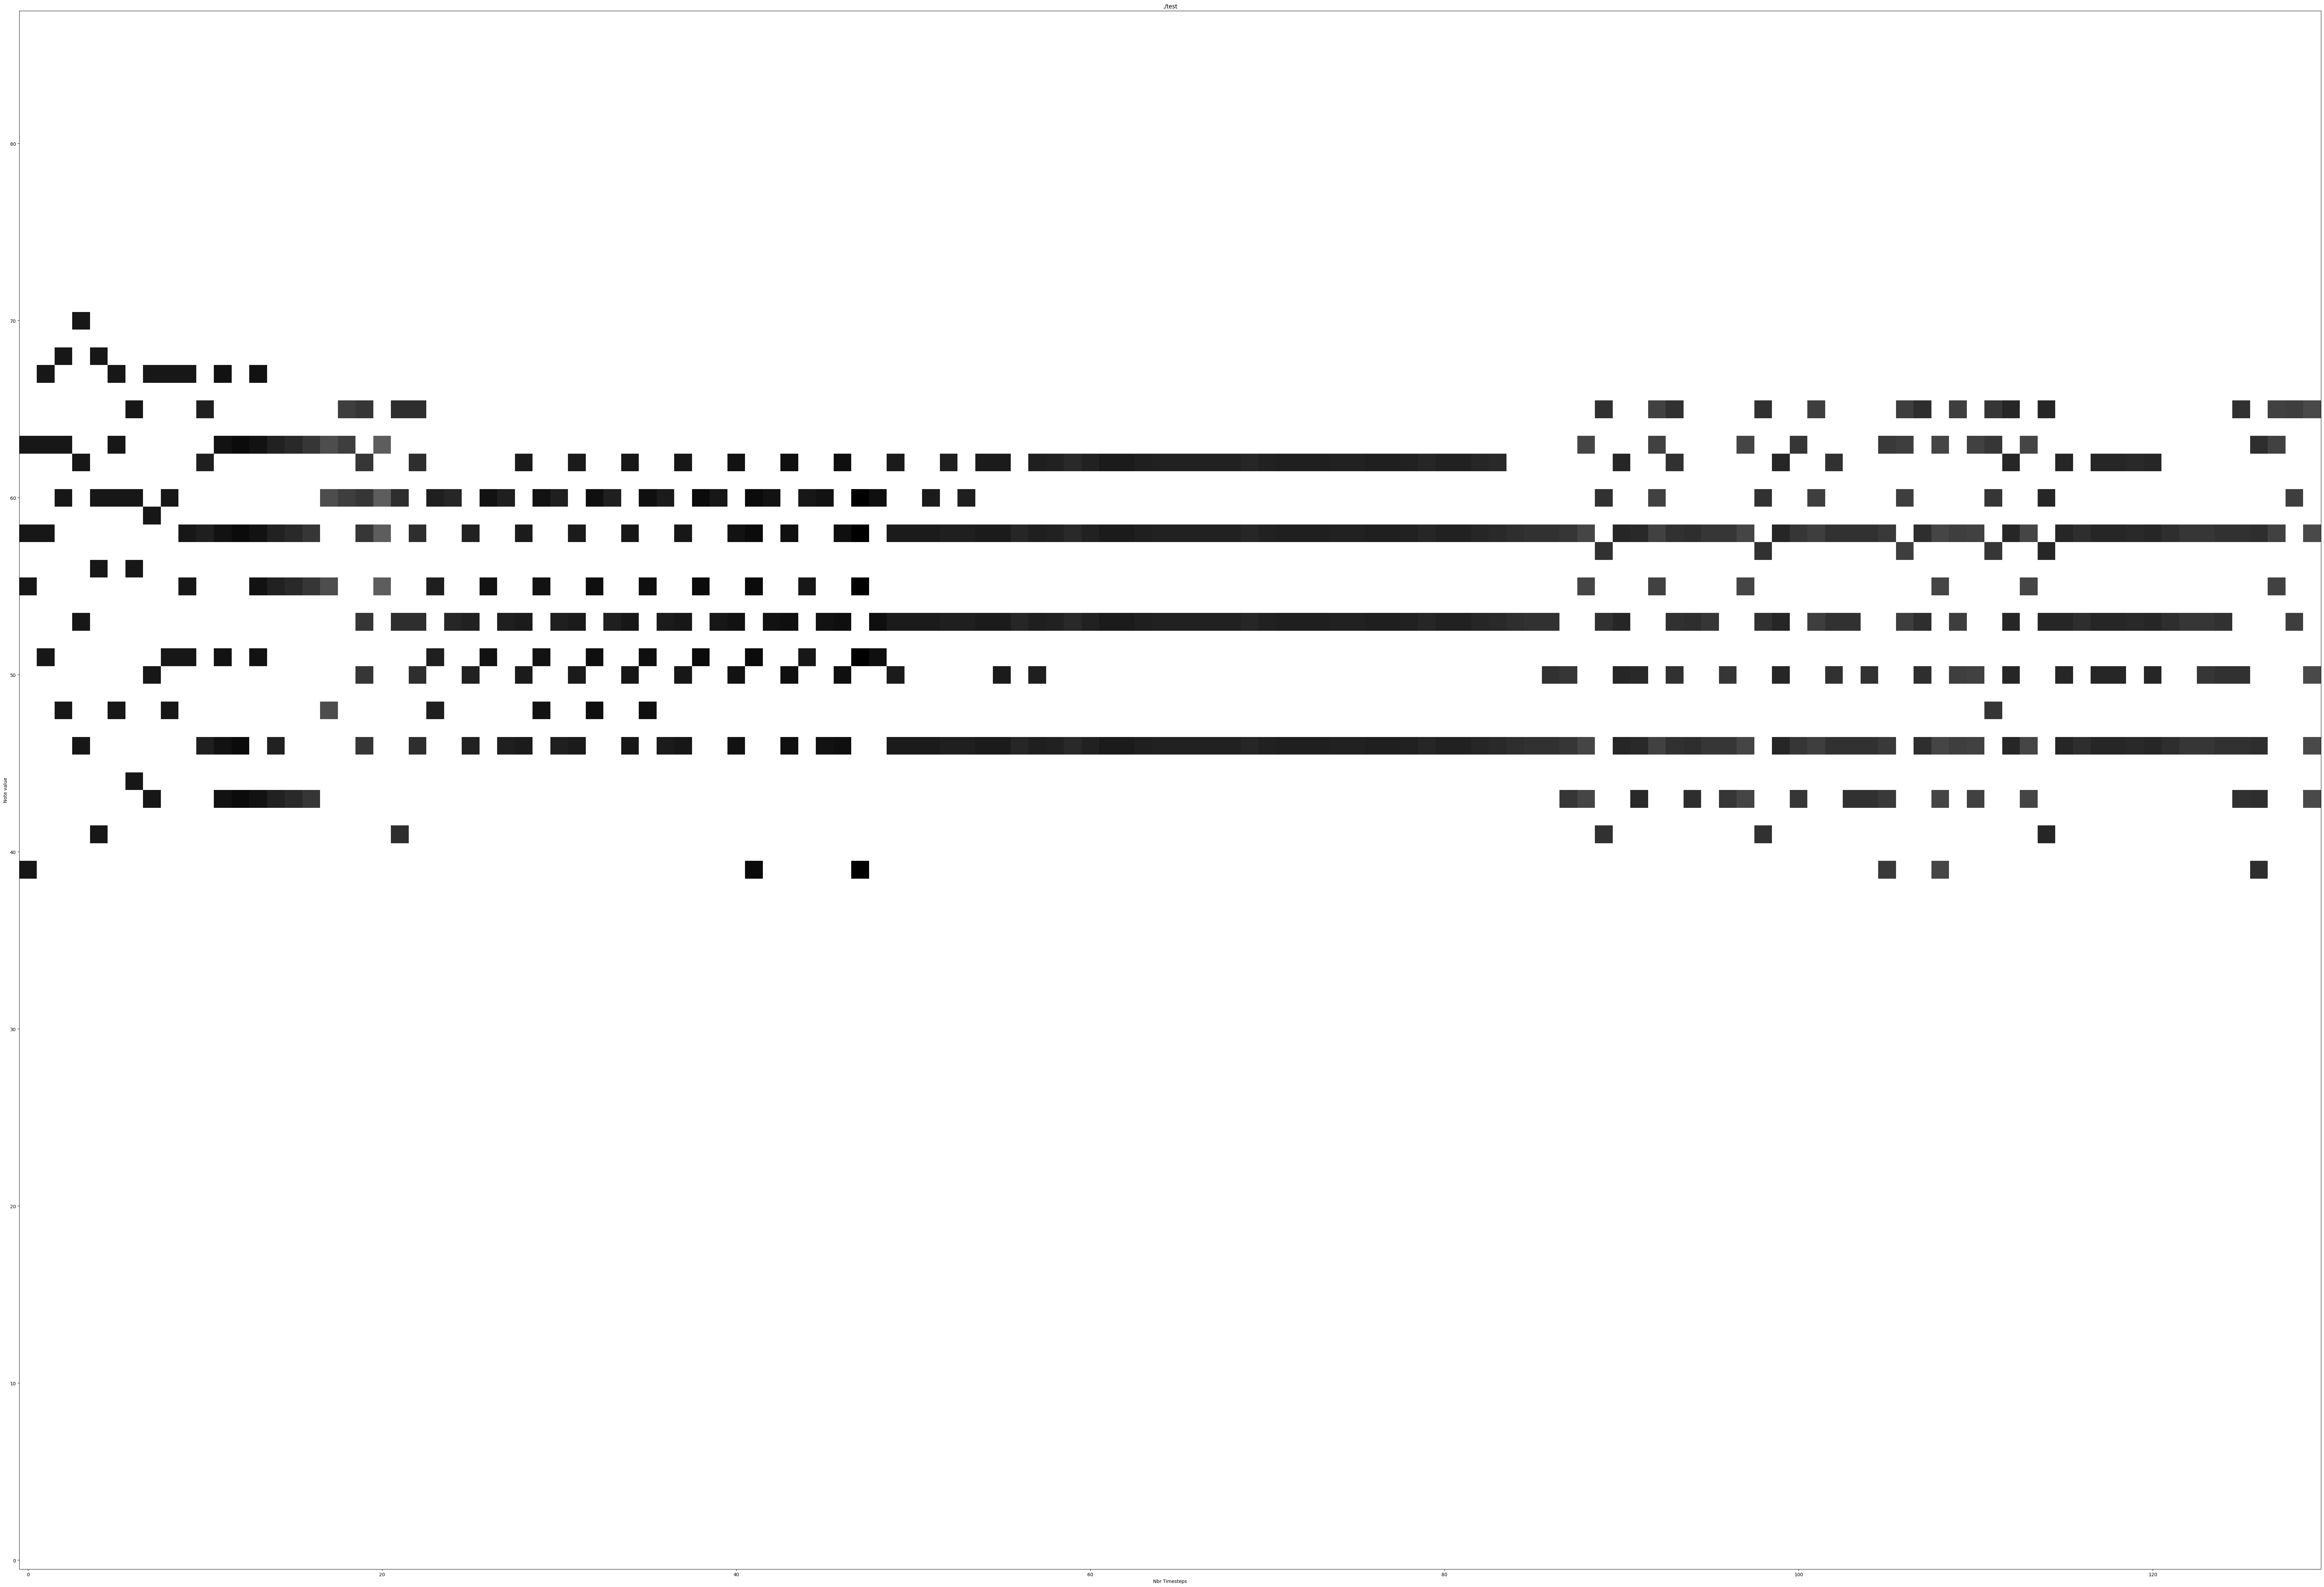

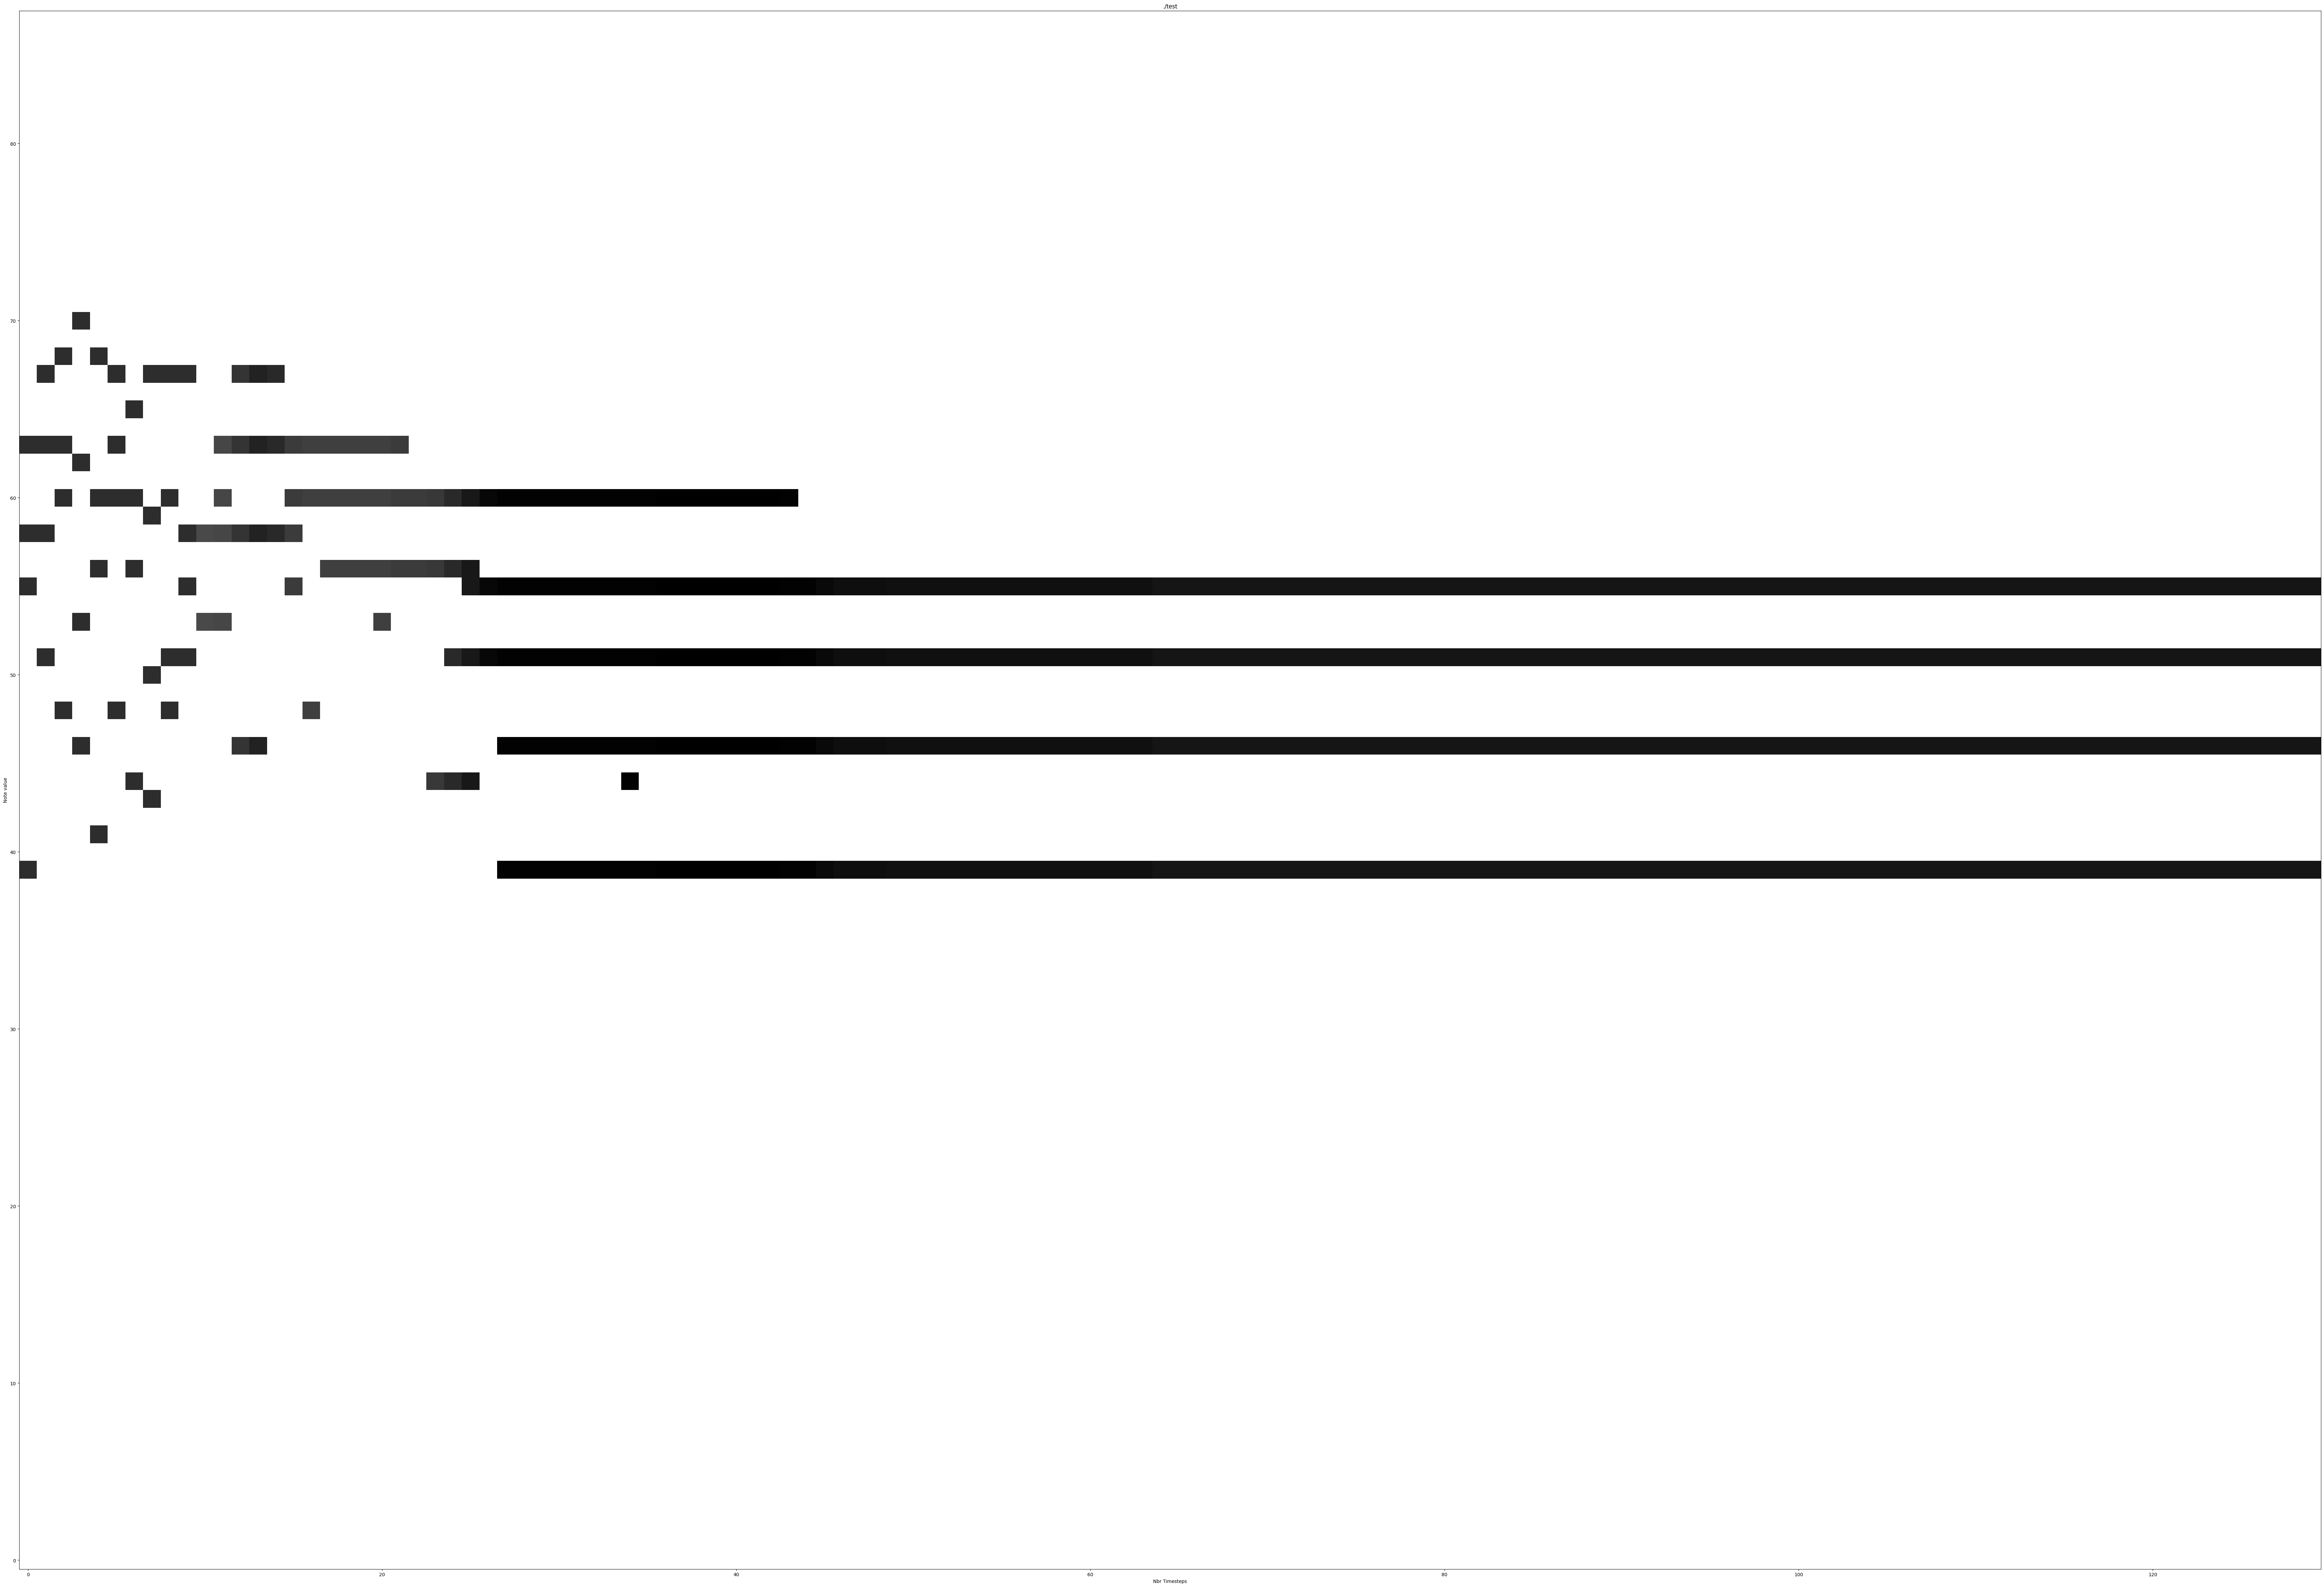

In [442]:
import torch
import pandas as pd

def generate_and_save(model, model_filename, output_csv, output_midi, model_type, window_size):
    # Sampling a music for generation
    dataset = PianoMusic("./js/mini", transform=transform)
    random_sample = dataset[random.randint(0, len(dataset)-1)]
    sample_chords = random_sample['chords']
    sample_durations = random_sample['durations']

    # Reloading the model
    model.load_state_dict(torch.load(model_filename))
    model = model.cpu()
    
    # Generating music based on a few notes of the sample
    roll, durations = generate(model, sample_chords[0:10], sample_durations[0:10], 120, None)
    
    # Cleaning the result
    pianoroll = torch.where(roll >= 1/16, 1, 0)
    pianoroll = pianoroll * durations.unsqueeze(-1)
    pianoroll = pianoroll.type(torch.int64)
    x_np = pianoroll.detach().numpy()
    x_df = pd.DataFrame(x_np)
    
    # Saving the generation as a CSV
    x_df.to_csv(output_csv)
    
    # Plotting the piano roll for visual feedback
    plotPianoRoll(pianoroll, path="./test")
    
    # Saving the generation as a MIDI
    create_midi(output_midi, pianoroll, 'Acoustic Grand Piano')

# Using the function for both model files
generate_and_save(model, 'model-last.pt', 'sample-last.csv', 'sample-last.mid', 'last', window_size=8)
generate_and_save(model, 'model-best.pt', 'sample-best.csv', 'sample-best.mid', 'best', window_size=8)
